In [2]:
import json
import os
import sys
import pickle
from tqdm import tqdm, trange

import pandas as pd    
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get openAI data

## Option 1: Load from pickle

In [6]:
# job_results = pickle.load(open('data/mmlu/mmlu-results_gpt35.pk', 'rb'))
job_results = pickle.load(open('data/mmlu/mmlu-results_dv3.pk', 'rb'))

## Option 2: query OpenAI

### Load MMLU dataset

In [3]:
# Before running this, clone the repo  https://github.com/hendrycks/test  into the directory `mmlu`
sys.path.append('./mmlu/')
from evaluate_flan import format_example, gen_prompt
from categories import subcategories, categories

data_dir = './mmlu/data/'

In [4]:
subjects = sorted([
    f.split("_test.csv")[0]
    for f in os.listdir(os.path.join(data_dir, "test"))
    if "_test.csv" in f
])

In [5]:
dfs = {}
for subject in subjects:
    subcats = subcategories[subject] 
    test_df = pd.read_csv(data_dir + f'test/{subject}_test.csv', header=None)
    dfs[subject] = test_df

In [8]:
test_df

,0,1,2,3,4,5
0,What can murtis be translated as?,Offerings,Prayers,Apparitions,Idols,D
1,Naturalists who concentrated on natural eleme...,Daoism,Yin-Yang School,Mengzi,Humanistic Buddhism,B
2,When was the first Buddhist temple constructe...,325 CE,119 CE,451 CE,596 CE,D
3,What is the name of the ten day New Year fest...,Akitu,Wag and Thoth,Bast,Nehebkau,A
4,Which of the following terms denote the Japane...,Zazen,Tariki,Kami,Ikebana,D
...,...,...,...,...,...,...
166,What has been a central focus of religious tra...,Peace and harmony,Power and influence,Truth and love,Wisdom and ethics,A
167,To whom did ordinary folk appeal during a dro...,The Buddha,Laozi,The Queen Mother of the West,Confucius,C
168,The theological term homoousios means which o...,of a similar substance,of the same substance,of like substance,of human substance,B
169,"According to the Japanese origin myth, who giv...",Es,Izanagi,Izanami,Kami,B


In [9]:
prompt_end = format_example(test_df, idx=0, include_answer=False)
train_prompt = gen_prompt(test_df, subject, k=0)

print(train_prompt + prompt_end)

The following are multiple choice questions (with answers) about  world religions.

 What can murtis be translated as?
A. Offerings
B. Prayers
C. Apparitions
D. Idols
Answer:


In [11]:
subcategories

{'abstract_algebra': ['math'],
 'anatomy': ['health'],
 'astronomy': ['physics'],
 'business_ethics': ['business'],
 'clinical_knowledge': ['health'],
 'college_biology': ['biology'],
 'college_chemistry': ['chemistry'],
 'college_computer_science': ['computer science'],
 'college_mathematics': ['math'],
 'college_medicine': ['health'],
 'college_physics': ['physics'],
 'computer_security': ['computer science'],
 'conceptual_physics': ['physics'],
 'econometrics': ['economics'],
 'electrical_engineering': ['engineering'],
 'elementary_mathematics': ['math'],
 'formal_logic': ['philosophy'],
 'global_facts': ['other'],
 'high_school_biology': ['biology'],
 'high_school_chemistry': ['chemistry'],
 'high_school_computer_science': ['computer science'],
 'high_school_european_history': ['history'],
 'high_school_geography': ['geography'],
 'high_school_government_and_politics': ['politics'],
 'high_school_macroeconomics': ['economics'],
 'high_school_mathematics': ['math'],
 'high_school_mi

In [12]:
cats = ['college_physics', 'elementary_mathematics', 'high_school_biology', 'high_school_psychology', 'philosophy']  # , 'world_religions']
tasks_per_cat = 2

mmlu_tasks = []

for subject in cats:
    test_df = dfs[subject]

    for i in range(tasks_per_cat):
    ### for i in range(test_df.shape[0]):

        rl = test_df.iloc[i].to_list()
        rd = {}
        
        prompt_end = format_example(test_df, idx=i, include_answer=False)
        train_prompt = gen_prompt(test_df, subject, k=0)
        prompt = train_prompt + prompt_end
        task = {
            'subject': subject,
            'idx': i,
            'prompt': prompt,
            
            'question': rl[0], 
            'answer': rl[5], 
            'A': rl[1], 
            'B': rl[2], 
            'C': rl[3], 
            'D': rl[4]
        }
        task.update(rd)
        mmlu_tasks.append(task)

### Call OpenAI

In [13]:
ht_flips = ['Heads', 'Tails'] * 10000
rand_flips = [['Heads', 'Tails'][i] for i in np.random.randint(0, 2, 10000)]

rand_flips[:15]

['Heads',
 'Tails',
 'Heads',
 'Tails',
 'Tails',
 'Heads',
 'Tails',
 'Tails',
 'Tails',
 'Heads',
 'Heads',
 'Heads',
 'Tails',
 'Heads',
 'Tails']

In [43]:
# ht_flips = [e for flip in ht_flips for e in (flip, ',')]
# rand_flips = [e for flip in rand_flips for e in (flip, ',')]
#
# ''.join(ht_flips[:20]).replace(',', ', ')

In [14]:
n_flips = 100

jobs_by_task = []

for task in mmlu_tasks:
    jobs = []
    for i in list(range(1, 100, 1)) + list(range(100, 1100, 100)):
        for flip_type, flips in [('ht', ht_flips)]:  #, ('rand', rand_flips)]:
            x = flips[:i]
            job = task.copy()
            job['flip_type'] = flip_type
            job['n_flips'] = i
            job['prompt'] = job['prompt'] + ' ' + ', '.join(x) + ','
            jobs.append(job)
    jobs_by_task.append(jobs)

In [15]:
len(jobs)

109

In [16]:
## possible approaches to estimating "did it get distracted?":
# 1. greedy decoding + plot token-wise probability of non-heads/tails token
#    - challenge: the exact non-heads/tails token will change significantly between tasks
# 2. stochestic decoding + compute % of completions that end with something other than heads/tails/,
#    - challenge: how to automatically compute whether a completion changed topics? ask another LLM?

In [17]:
jobs_by_task[9][0]

{'task': 'mmlu',
 'subject': 'philosophy',
 'idx': 1,
 'prompt': 'The following are multiple choice questions (with answers) about  philosophy.\n\nFor Socrates, an unexamined life is a tragedy because it results in grievous harm to _____.\nA. the state\nB. the justice system\nC. the body\nD. the soul\nAnswer: Heads,',
 'question': 'For Socrates, an unexamined life is a tragedy because it results in grievous harm to _____.',
 'answer': 'D',
 'A': 'the state',
 'B': 'the justice system',
 'C': 'the body',
 'D': 'the soul',
 'flip_type': 'ht',
 'n_flips': 1}

In [18]:
jobs_by_task[6][0]

{'task': 'mmlu',
 'subject': 'high_school_psychology',
 'idx': 0,
 'prompt': 'The following are multiple choice questions (with answers) about  high school psychology.\n\nNearsightedness results from\nA. too much curvature of the cornea and lens\nB. too little curvature of the cornea and lens\nC. too much curvature of the iris and lens\nD. too little curvature of the iris and lens\nAnswer: Heads,',
 'question': 'Nearsightedness results from',
 'answer': 'A',
 'A': 'too much curvature of the cornea and lens',
 'B': 'too little curvature of the cornea and lens',
 'C': 'too much curvature of the iris and lens',
 'D': 'too little curvature of the iris and lens',
 'flip_type': 'ht',
 'n_flips': 1}

In [19]:
jobs_by_task[7][0]

{'task': 'mmlu',
 'subject': 'high_school_psychology',
 'idx': 1,
 'prompt': 'The following are multiple choice questions (with answers) about  high school psychology.\n\nDelusions of grandeur are most characteristic of\nA. OCD.\nB. schizophrenia.\nC. conversion disorder.\nD. antisocial personality disorder.\nAnswer: Heads,',
 'question': 'Delusions of grandeur are most characteristic of',
 'answer': 'B',
 'A': 'OCD.',
 'B': 'schizophrenia.',
 'C': 'conversion disorder.',
 'D': 'antisocial personality disorder.',
 'flip_type': 'ht',
 'n_flips': 1}

In [20]:
jobs[0]['prompt']

'The following are multiple choice questions (with answers) about  philosophy.\n\nFor Socrates, an unexamined life is a tragedy because it results in grievous harm to _____.\nA. the state\nB. the justice system\nC. the body\nD. the soul\nAnswer: Heads,'

In [ ]:
import batch_prompt

In [ ]:

# job_res = []
# jobs = jobs_by_task[16]


job_results = []
for jobs in tqdm(jobs_by_task):
    job_res = batch_prompt.completions(
        [d['prompt'] for d in jobs], 
        queries_per_batch=10,
        model_args={
            'max_tokens': 5, 
            'logprobs': 5, 
            'engine': 'text-davinci-003',     # Note: this model no longer available :(
            'temperature': 0}, 
        verbose=1
    )
        
    res_jobs = [job.copy() for job in jobs]
    for r, job in zip(job_res, res_jobs):
        job['choice'] = r['choice']
    
    job_results.append(res_jobs)

In [ ]:
# save
pickle.dump(job_results, open('mmlu_results.pk', 'wb'))

## Convert data to df

In [7]:
def strip_space(s):
    if len(s) <= 1:
        return s
    if s[0] == ' ':
        s = s[1:]
    if s[-1] == ' ':
        s = s[:-1]
    return s

def does_match(match_str, tok_lps):
    probs = [p for tok, p in tok_lps.items()
             if any([strip_space(tok).lower() == s.lower() for s in match_str])]
    
    if len(probs) == 0:
        return 0.
        
    return sum(np.exp(probs))

In [8]:
distract_res = []
for res_jobs in job_results:
    for job in res_jobs:
        t_lp = job['choice']['logprobs']['top_logprobs'][0]
        d = {
            'task': job['task'],
            'subject': job['subject'],
            'idx': job['idx'],
            'n_flips': job['n_flips'],
            
            'Flips': does_match(['H', 'eads', 'Heads', 'T', 'Tails', 'ails', ','], t_lp),
            'A': does_match(['A'], t_lp),
            'B': does_match(['B'], t_lp),
            'C': does_match(['C'], t_lp),
            'D': does_match(['D'], t_lp),
            'Answer': does_match(['Answer', '\n'], t_lp),
        }
        distract_res.append(d)

distract_df = pd.DataFrame(distract_res)
distract_df['NonFlip'] = distract_df['A'] + distract_df['D'] + distract_df['C'] + distract_df['D'] + distract_df['Answer']

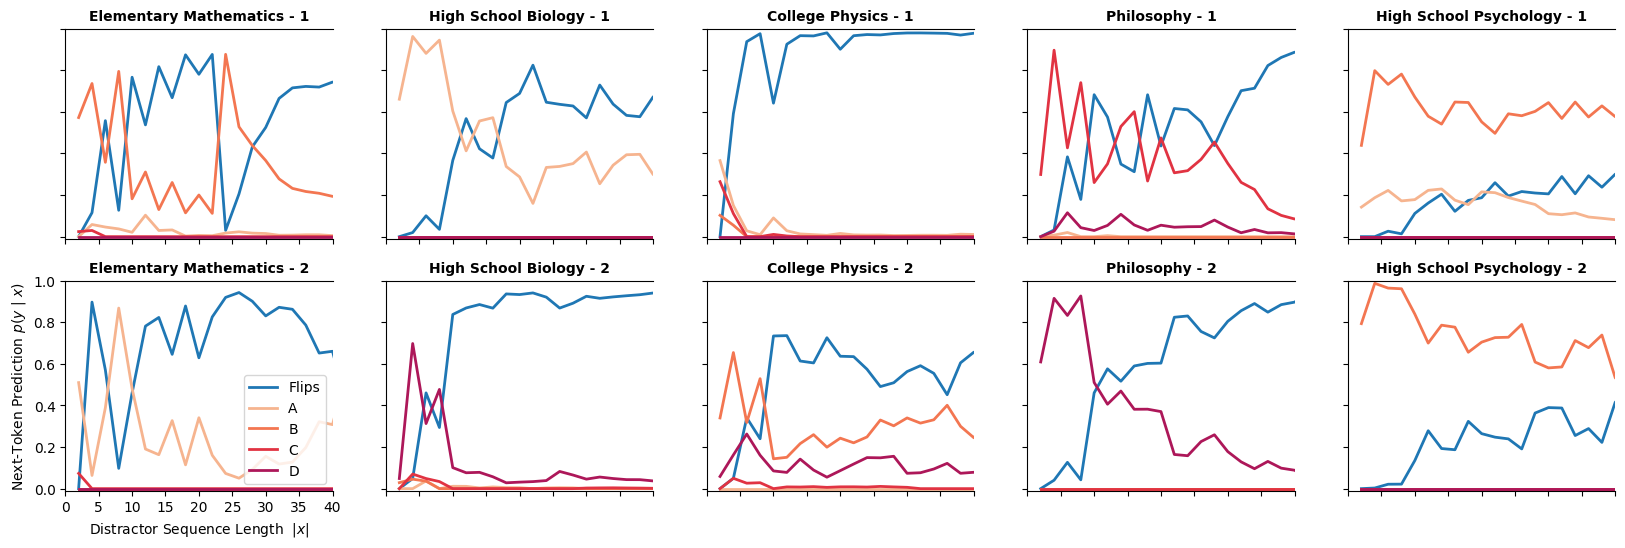

In [9]:
plt.rcParams['figure.figsize'] = (20, 6)

palette = sns.color_palette('rocket_r', n_colors=6)
palette = palette#[1:5]

for si, subject in enumerate(set(distract_df.subject)):
    for idx in [0, 1]:
        plt.subplot(2, 5, si + idx*5 + 1)
        ddf_ = distract_df[distract_df['n_flips'] % 2 == 0]
        ddf_ = ddf_[ddf_['subject'] == subject]
        ddf_ = ddf_[ddf_['idx'] == idx]
        
        sns.lineplot(data=ddf_, x='n_flips', y='Flips', label='Flips', lw=2)
        # sns.lineplot(data=distract_df, x='n_flips', y='Flips', label='Flips')
        # sns.lineplot(data=distract_df, x='n_flips', y='NonFlip', label='NonFlips')
        sns.lineplot(data=ddf_, x='n_flips', y='A', label='A', lw=2, color=palette[0])
        sns.lineplot(data=ddf_, x='n_flips', y='B', label='B', lw=2, color=palette[1])
        sns.lineplot(data=ddf_, x='n_flips', y='C', label='C', lw=2, color=palette[2])
        sns.lineplot(data=ddf_, x='n_flips', y='D', label='D', lw=2, color=palette[3])
        # sns.lineplot(data=distract_df, x='n_flips', y='Answer', label='Answer')
        plt.xlim(0, 100);
        plt.title(f'{subject.replace("_"," ").title()} - {idx + 1}', fontsize=10, weight='bold')
        sns.despine(top=False)
        plt.ylim(-.01, 1.0)

        # plt.hlines(1.0, 0, 100, ls='--', color='grey')
        
        if si == 0 and idx == 1 :
            plt.ylabel('Next-Token Prediction $p(y \ | \ x)$')
            plt.xlabel('Distractor Sequence Length  $|x|$')
            plt.legend(loc='upper right')
            plt.xticks(list(range(0, 45, 5)), list(range(0, 45, 5)))
            plt.legend(loc='lower right')
        else:
            plt.xlabel(None)
            plt.ylabel(None)
            plt.yticks([0, .2, .4, .6, .8, 1.0], [])
            # plt.xticks([0, 20, 40, 60, 80, 100], [])
            plt.xticks(list(range(0, 45, 5)), [])
            plt.gca().get_legend().remove()
        plt.xlim(0, 40);
        # plt.yscale('log')

# plt.savefig('imgs/distract-mmlu.pdf')
plt.show()